<a href="https://colab.research.google.com/github/vesran/Aspect-Based-Sentiment-Analysis/blob/main/experiments/Sentiments_segmenter_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers


In [2]:
df_semeval = pd.read_csv('sentiments_semeval.csv', sep=';')

In [3]:
df_yelp = pd.read_csv('sentiments_yelp.csv', sep=';')

In [4]:
df_semeval.head()

,sentence,clean_sentence,label,source
0,But the staff was so horrible to us.,but staff horrible,0,train
1,"The food is uniformly exceptional, with a very...",food uniformly exceptional with very capable k...,1,train
2,Where Gabriela personaly greets you and recomm...,gabriela personal greet recommend eat,1,train
3,"For those that go once and don't enjoy it, all...",those go once not enjoy can say not get,1,train
4,"Not only was the food outstanding, but the lit...",not food outstanding but little perk great,1,train


In [5]:
df_yelp['source'] = 'train'
df_yelp = df_yelp[['sentence', 'clean_sentence', 'label', 'source']].copy()
df_yelp.head()

,sentence,clean_sentence,label,source
0,The food is fresh and so delicious!,food fresh so delicious,1,train
1,Came here on Sunday for dinner and ended up wa...,come here sunday dinner end up wait food hrs n...,0,train
2,I really think alot before even coming to this...,really think lot before even come location,0,train
3,A much needed addition to Winter Park and Orla...,much need addition winter park orlando general,1,train
4,10. international airport,international airport,1,train


In [6]:
df_semeval = df_semeval[df_semeval.source.isin(['train', 'val'])]

In [7]:
df_semeval['origin'] = 'semeval'
df_yelp['origin'] = 'yelp'

In [8]:
df = pd.concat([df_semeval, df_yelp])

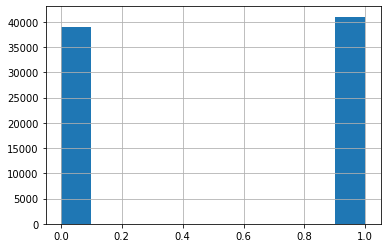

In [9]:
df.label.hist()

In [10]:
df = df[df.clean_sentence.notnull()].copy()

In [11]:
df['num_w'] = df.clean_sentence.apply(lambda x: len(x.split(' ')))

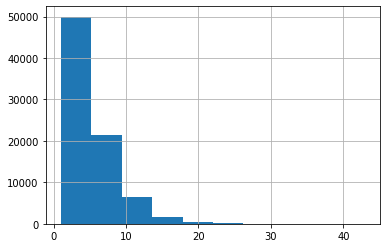

In [12]:
df['num_w'].hist()

In [13]:
df.num_w.describe()

count    79925.000000
mean         5.270078
std          3.319242
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         43.000000
Name: num_w, dtype: float64

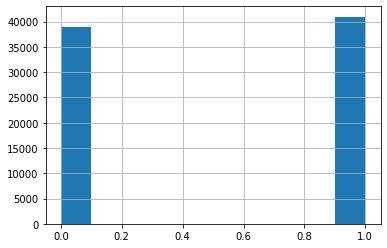

In [14]:
df.label.hist()

In [15]:
sents = df[df.num_w <= 15].copy()

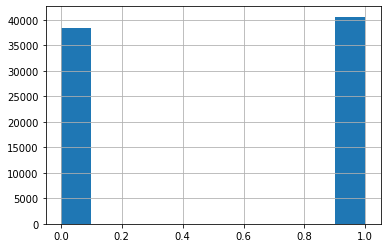

In [16]:
sents.label.hist()

In [17]:
pos = sents.query("label == 1").copy()
neg = sents.query("label == 0").copy()
posneg = pd.concat([pos, neg]).sample(frac=1)

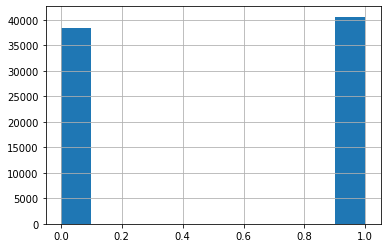

In [18]:
posneg.label.hist()

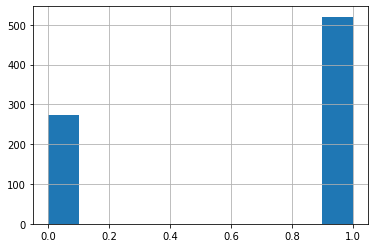

In [19]:
posneg.query("source=='val'").label.hist()

In [20]:
posneg['tokens'] = posneg.clean_sentence.apply(lambda x: x.split(' '))
posneg['tags'] = posneg.apply(lambda x: [x['label']] * len(x['tokens']), axis=1)

In [21]:
train = posneg.query("source == 'train'").copy()
val = posneg.query("source == 'val'").copy()

In [22]:
train.shape

(78114, 8)

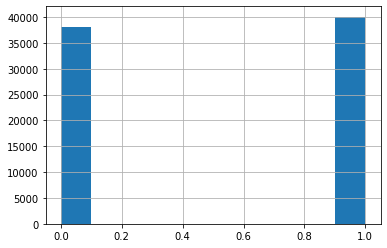

In [23]:
train.label.hist()

In [24]:
val_pos = val.query("label==1").sample(frac=1).head(300).copy()
val_neg = val.query("label==0").copy()

In [25]:
val = pd.concat([val_pos, val_neg]).sample(frac=1)

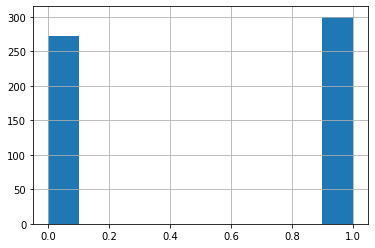

In [26]:
val.label.hist()

In [29]:
max_len = 30

In [30]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
import tensorflow as tf
import numpy as np


def import_GloVe(path):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word.encode()] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
    return embeddings_index


def prepare_embedding_matrix(embeddings_index, word_index, num_tokens, embedding_dim, binary=False):
    hits, misses = 0, 0
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word if binary else word.encode())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print(f'Hits : {hits} | Misses : {misses}')
    return embedding_matrix


class PretrainedEmbedding(tf.keras.Model):

    def __init__(self, **kwargs):
        super(PretrainedEmbedding, self).__init__()

    def adapt(self, corpus, path, method='glove100'):
        binary = path.split('.')[-1] == 'bin'

        # Build vectorizer
        self.vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_len)
        text_ds = tf.data.Dataset.from_tensor_slices(corpus).batch(128)
        self.vectorizer.adapt(text_ds)

        # Word to index
        voc = self.vectorizer.get_vocabulary()
        self.word_index = dict(zip(voc, range(2, len(voc))))

        # Load embeddings
        self.method = method
        embeddings2index = import_GloVe(path)
        emb_dim = 100

        # Create embedding layer
        self.embedding_matrix = prepare_embedding_matrix(embeddings2index, self.word_index, num_tokens=len(voc)+2,
                                                    embedding_dim=100, binary=binary)
        self.embedding_layer = Embedding(len(voc) + 2, emb_dim,
                                         embeddings_initializer=tf.keras.initializers.Constant(self.embedding_matrix),
                                         trainable=False)

    def call(self, string_inputs):
        x = self.vectorizer(string_inputs)
        embs = self.embedding_layer(x)
        return embs


In [31]:
p = PretrainedEmbedding()
p.adapt(train.clean_sentence, './glove.6B.100d.txt')

Found 400000 word vectors.
Hits : 12775 | Misses : 654


In [32]:
def complete(li, max_len):
    li = li + [li[-1]] * (max_len - len(li))
    li = li[:max_len]
    assert len(li) == max_len
    return li


In [35]:
from tensorflow.keras.utils import Sequence
import numpy as np   
import random

class DataGen(Sequence):
    def __init__(self, x, y, batch_size):
        self.y1 = y[::2]
        self.y2 = y[1::2]
        self.x1 = x[::2]  # Tous les éléments d'indice pair
        self.x2 = x[1::2] # Tousl les éléments d'indice impair
        self.batch_size = batch_size

    def __len__(self):
        return int(0.5 * np.ceil((len(self.x1) + len(self.x2)) / float(self.batch_size)))

    def __getitem__(self, idx):
        order1 = list(range(self.batch_size))
        order2 = list(range(self.batch_size))
        random.shuffle(order1), random.shuffle(order2)

        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) * self.batch_size][order1]
        batch_x2 = self.x2[idx * self.batch_size:(idx + 1) * self.batch_size][order2]
        batch_y1 = self.y1[idx * self.batch_size:(idx + 1) * self.batch_size][order1].tolist()
        batch_y2 = self.y2[idx * self.batch_size:(idx + 1) * self.batch_size][order2].tolist()

        # read your data here using the batch lists, batch_x and batch_y
        x = [batch_x1[i] + " " + batch_x2[i] for i in range(self.batch_size)] 
        y = [complete(batch_y1[i] + batch_y2[i], max_len) for i in range(self.batch_size)]
        return np.array(x), np.array(y)


d = DataGen(train['clean_sentence'].head(10).values, train['tags'].head(10).values, 4)

In [36]:
d[0]

(array(['never eat here again food atrocious throw together quick bartender know their craft',
        'stupid archaic policy very clean',
        'favourite brisket taco street corn stay away',
        'love unfortunate due fact food amazing cool vibe'], dtype='<U83'),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]))

In [96]:
def get_model():
    inp = tf.keras.Input(shape=(1, ), dtype='string')
    x = inp
    x = p(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.TimeDistributed(layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.001)))(x)

    model = tf.keras.Model(inputs=inp, outputs=out)
    return model


model = get_model()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
pretrained_embedding_1 (Pret (None, 30, 100)           1343300   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 30, 256)           176640    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 30, 256)           296448    
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 30, 256)           296448    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 30, 256)           2964

In [97]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["acc"])

batch_size = 128
datagen = DataGen(train['clean_sentence'].values, train['tags'].values, batch_size)
val_datagen = DataGen(val['clean_sentence'].values, val['tags'].values, batch_size)

hist = model.fit(datagen, epochs=15, validation_data=val_datagen,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/20
305/305 [==============================] - 167s 518ms/step - loss: 0.6569 - acc: 0.6779 - val_loss: 0.5406 - val_acc: 0.7634
Epoch 2/20
305/305 [==============================] - 161s 528ms/step - loss: 0.4916 - acc: 0.7874 - val_loss: 0.4642 - val_acc: 0.8164
Epoch 3/20
305/305 [==============================] - 159s 522ms/step - loss: 0.4430 - acc: 0.8164 - val_loss: 0.4748 - val_acc: 0.7988
Epoch 4/20
305/305 [==============================] - 158s 518ms/step - loss: 0.4245 - acc: 0.8263 - val_loss: 0.4270 - val_acc: 0.8125
Epoch 5/20
305/305 [==============================] - 156s 510ms/step - loss: 0.4027 - acc: 0.8384 - val_loss: 0.4137 - val_acc: 0.8257
Epoch 6/20
305/305 [==============================] - 157s 516ms/step - loss: 0.3866 - acc: 0.8459 - val_loss: 0.4071 - val_acc: 0.8302
Epoch 7/20
305/305 [==============================] - 156s 512ms/step - loss: 0.3757 - acc: 0.8517 - val_loss: 0.4122 - val_acc: 0.8292
Epoch 8/20
305/305 [============================

In [98]:
model_name = 'anaseq_003'
model.save(model_name)

import shutil
shutil.make_archive(model_name, 'zip', model_name)

INFO:tensorflow:Assets written to: anaseq_003/assets


'/content/anaseq_003.zip'

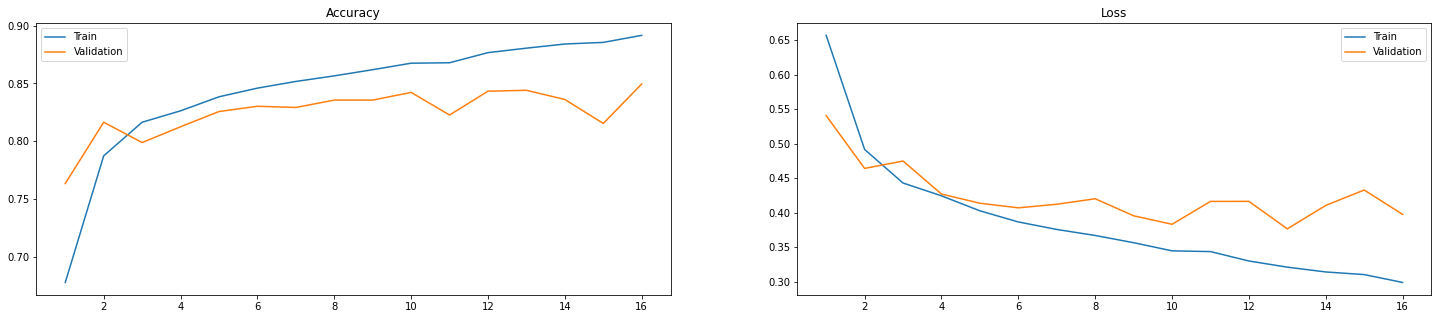

In [99]:
def plot_hist(hist):
    h = hist.history
    _, axs = plt.subplots(1, 2, figsize=(25, 5))
    axs = np.ravel(axs)
    ax = axs[0]
    ax.plot(range(1, len(h['acc'])+1), h['acc'], label='Train')
    ax.plot(range(1, len(h['val_acc'])+1), h['val_acc'], label='Validation')
    ax.set_title('Accuracy')
    ax.legend()
    ax = axs[1]
    ax.plot(range(1, len(h['loss'])+1), h['loss'], label='Train')
    ax.plot(range(1, len(h['val_loss'])+1), h['val_loss'], label='Validation')
    ax.set_title('Loss')
    ax.legend();

plot_hist(hist)

In [69]:
testset = pd.read_csv('sentiments_testset.csv', sep=';')

In [104]:
def debug_infer(df, i, model):
    print(df.sentence.iloc[i])
    text = df.sentence.iloc[i]
    pred = model.predict(np.array([text]).reshape(-1, 1)).flatten()
    tokens = df.clean_sentence.iloc[i].split(' ')
    for k, (p, w) in enumerate(zip(pred, tokens)):
        if "tags" in df.columns:
            print(df.tags.iloc[i][k], p, w)
        else:
            print(p, w)

debug_infer(testset, 63, model)

The food was delicious and clearly fresh ingredients were used.
0.2796969 food
0.2355054 delicious
0.25021696 clearly
0.31727114 fresh
0.2407804 ingredient
0.23215461 use


In [105]:
debug_infer(val, 47, model)

– I am exceedingly pleased to report that my dinner at Ray's Boathouse last Friday completely exceeded my expectations.
1 0.39792973 exceedingly
1 0.34612033 pleased
1 0.34111503 report
1 0.41353264 dinner
1 0.40598193 ray
1 0.30500928 boathouse
1 0.26381928 last
1 0.2509886 friday
1 0.2339634 completely
1 0.22444998 exceed
1 0.20661795 expectation


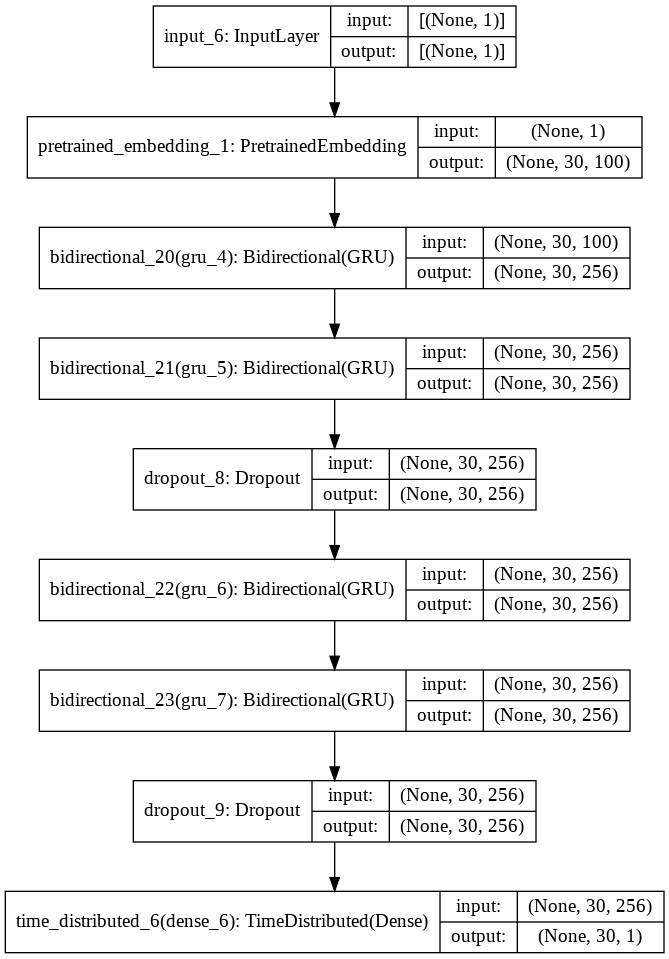

In [106]:
tf.keras.utils.plot_model(
    model, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=False, dpi=96
)